# Star 

## Packages

In [1]:
import numpy as np
from numpy import correlate
import matplotlib.pyplot as plt
import skysimulation.display as dpl
import skysimulation.stuff as stf
import skysimulation.field as fld
import skysimulation.restoration as rst
from skysimulation.stuff import NDArray, sqr_mask, ArrayLike

## Sky Generation

### Initial Parameters

In [2]:
mass_seed = fld.M_SEED
pos_seed  = fld.POS_SEED
bkg_seed  = fld.BACK_SEED
det_seed  = fld.NOISE_SEED
# mass_seed = None
# pos_seed  = None
# bkg_seed  = None
# det_seed  = None
method = 'rl'
# method = None
last_sen = []

kwargs = {}

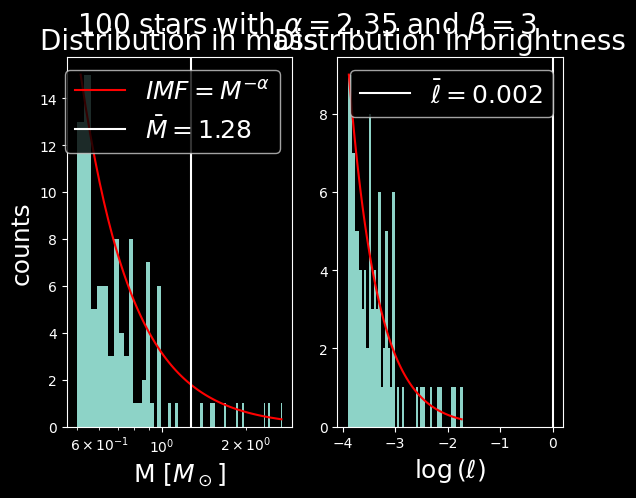

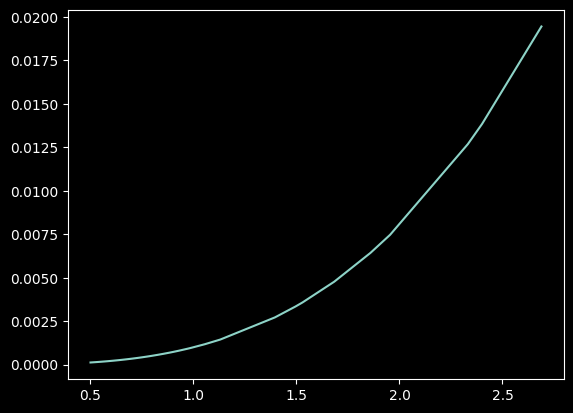

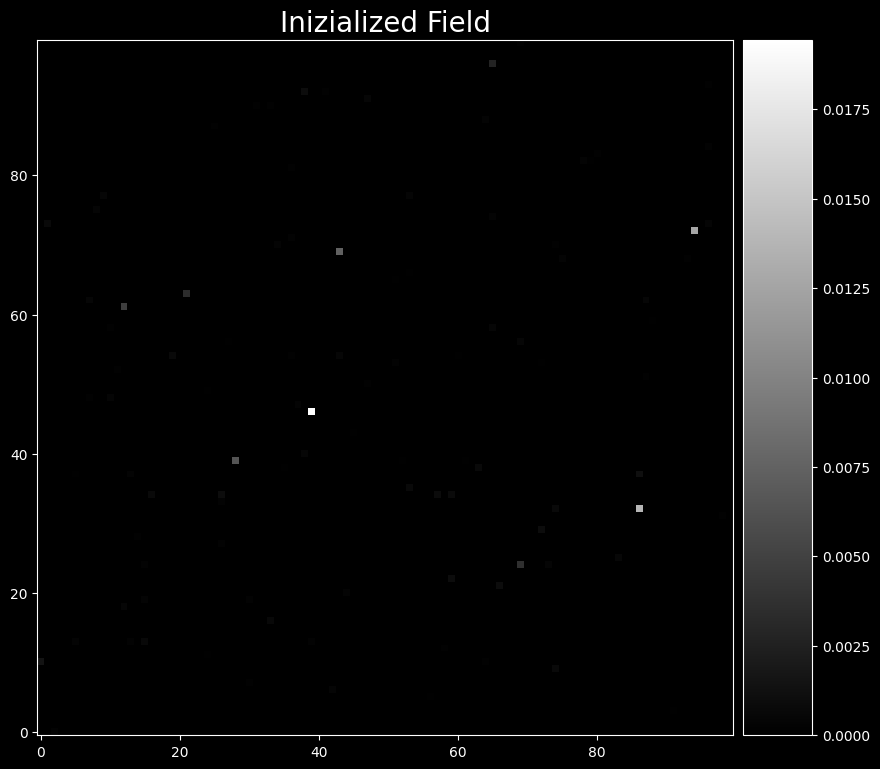

In [3]:
_ = fld.initialize(display_fig=True)

### Sky

----------
Initialization of the field
Dimension:	100 x 100
Number of stars:	100

- - - Background - - -
Gaussian distribution
mean:	0.2
sigma:	0.04000000000000001

- - - Detector noise - - -
Gaussian distribution
mean:	0.05
sigma:	0.025

Atm Seeing:
Gaussian distribution
sigma:	3


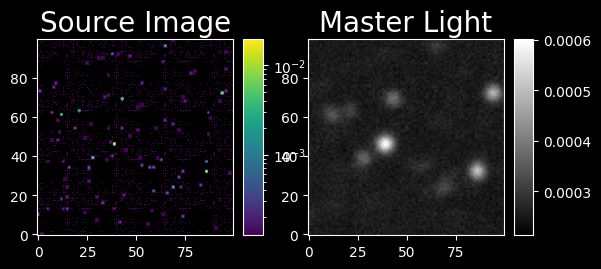

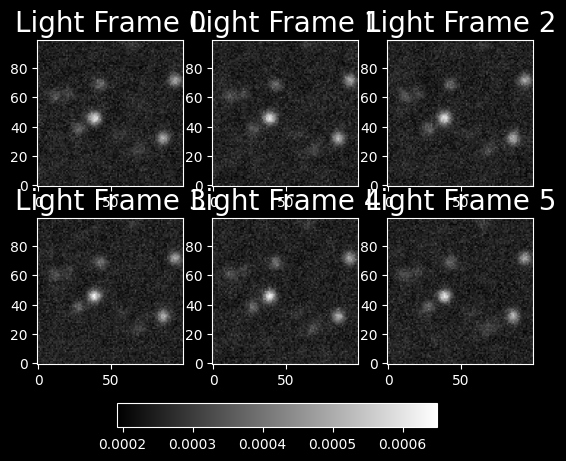

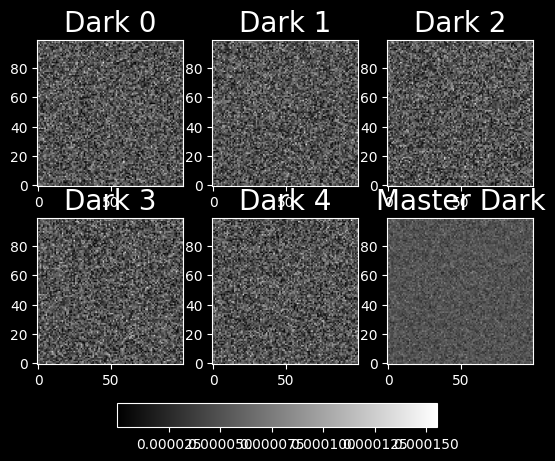

SIGMA = 1.4352429787848881e-05 +- 3.287957273492202e-06


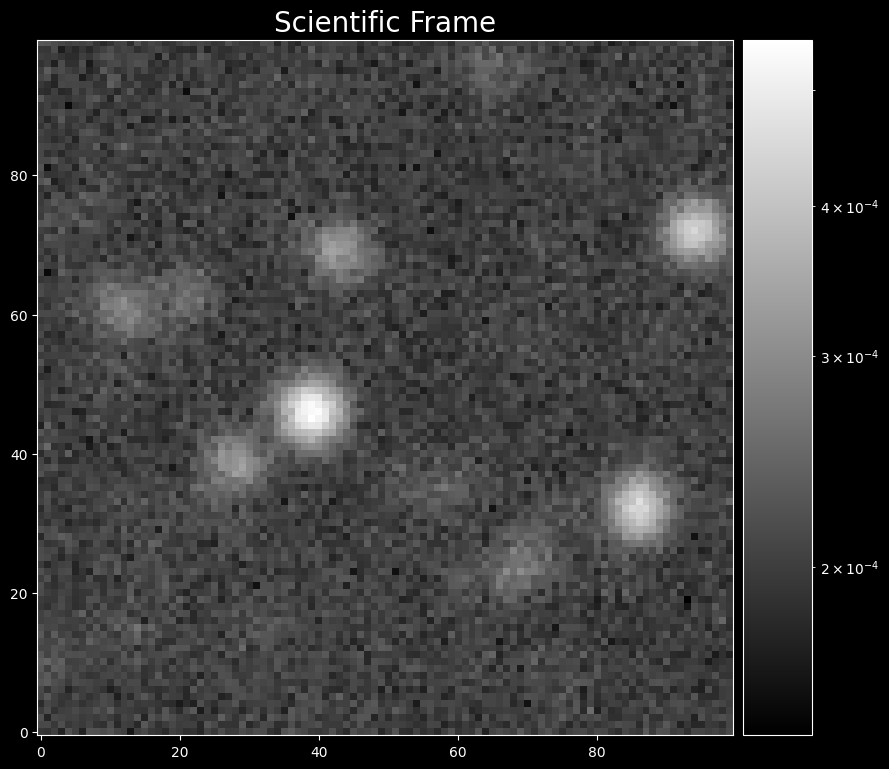

!!CHECK!!	 67


In [4]:
# generate the field
S, (m_light, s_light), (m_dark, s_dark) = fld.field_builder(seed=(mass_seed,pos_seed), back_seed=bkg_seed, det_seed=det_seed,**kwargs)
last_sen += [f'L0: {S.lum.max()}\nL0.5: {m_light.max()*np.sqrt(18*np.pi)}']
# compute the scientific frame
sci_frame = m_light - m_dark
last_sen += [f'L1: {sci_frame.max()*np.sqrt(18*np.pi)}']
# compute the uncertainty
sigma = np.sqrt(s_light**2 + s_dark**2)
m_sigma = sigma.mean()
s_sigma = sigma.std()
print(f'SIGMA = {m_sigma} +- {s_sigma}')
dpl.fast_image(sci_frame,'Scientific Frame',norm='log')
print('!!CHECK!!\t',len(np.where(S.lum > fld.BACK_MEAN*fld.K)[0]))


## Restoration

### Background Estimation


Background estimation
	mean:	0.00020592632307982686
	sigma:	1.7603122222848965e-05
	relerr:	8.55 %
Back 0.0002 4.000000000000001e-05
0.00020592632307982686
3.1226618791016855e-05
0.0002671859679477874


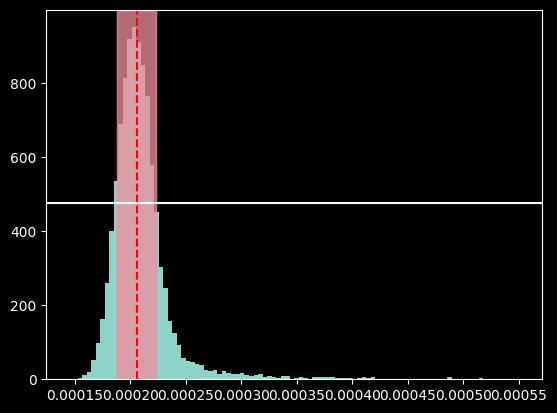

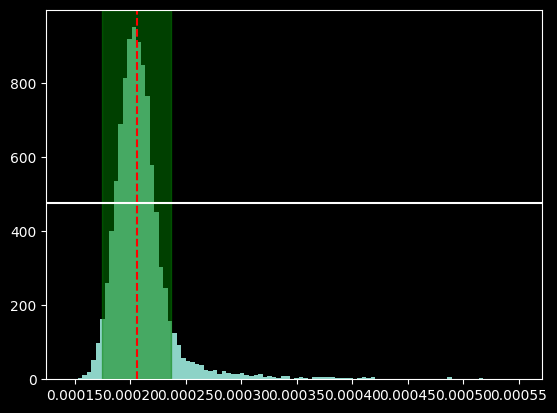

In [5]:
max_size = 5
# compute the average dark value
mean_dark = m_dark.mean()
# estimate background value
m_bkg, sigma_bkg = rst.bkg_est(sci_frame)
mean_bkg, Dmean_bkg = m_bkg
print('Back',fld.BACK_MEAN*fld.K, fld.BACK_SIGMA*fld.K)
med = np.median(sci_frame)
var = np.sqrt(np.var(sci_frame[sci_frame<6e-4],ddof=1))
print(med)
print(var)
print(2*med-sci_frame.min())
plt.figure()
valbin,_,_ = plt.hist(sci_frame.flatten(),sci_frame.shape[0])
plt.axvline(mean_bkg,0,1,color='red',linestyle='dashed')
plt.axvspan(mean_bkg-sigma_bkg,mean_bkg+sigma_bkg,color='orange',alpha=0.5)
plt.axvspan(mean_bkg-Dmean_bkg,mean_bkg+Dmean_bkg,color='violet',alpha=0.5)
plt.axhline(valbin.max()/2,0,1)
plt.figure()
valbin,_,_ = plt.hist(sci_frame.flatten(),sci_frame.shape[0])
plt.axvline(med,0,1,color='red',linestyle='dashed')
plt.axvspan(med-var,med+var,color='green',alpha=0.5)
plt.axhline(valbin.max()/2,0,1)
plt.show()

### Kernel Estimation

#### New Searching

In [6]:


def art_obj(prb_obj: NDArray, index: tuple[int,int], bkg_val: float, errs: NDArray | None = None, ker_sigma: float | None = None) -> tuple[NDArray,NDArray] | tuple[None,None]:
    fit_obj = prb_obj.copy() - bkg_val
    # prb_x, prb_y = index
    avg_cen = index 
    def gauss_func(pos, *args):
        xpos, ypos = pos
        k, s, x0, y0 = args
        zx = (xpos-x0)/s
        zy = (ypos-y0)/s
        return k * np.exp(-zx**2/2) * np.exp(-zy**2/2)
    xdim, ydim = prb_obj.shape
    xrange, yrange = np.meshgrid(np.arange(ydim),np.arange(xdim))
    from scipy.optimize import curve_fit
    try:
        k0 = fit_obj[index]
    except:
        dpl.fast_image(fit_obj)
        print(index)
    if ker_sigma is None:
        hm = k0/2
        hm_xpos, hm_ypos = stf.minimum_pos(abs(hm-fit_obj))
        hwhm = np.sqrt((hm_xpos - index[0])**2 + (hm_ypos - index[1])**2)
        ker_sigma = hwhm   
    initial_values = [k0,ker_sigma,index[0],index[1]]  
    xfit = np.vstack((xrange.ravel(),yrange.ravel()))
    yfit = fit_obj.ravel()
    errs = errs.ravel().copy() if errs is not None else None

    try:
        pop, pcov = curve_fit(gauss_func,xfit,yfit,initial_values,sigma=errs)
        if np.inf in pcov:
            return None, None
        print(pop,np.sqrt(pcov.diagonal()))
    except RuntimeError:
        return None, None
    except ValueError:
        print('YOHEY',errs.shape,fit_obj.shape)
        raise
    
    rec_obj = gauss_func((xrange,yrange),*pop) + bkg_val
    print('VARIANCE',np.sqrt(np.var(rec_obj-prb_obj)))
    rec_err = np.full(rec_obj.shape,np.sqrt(np.var(rec_obj-prb_obj)))
    if rec_obj.shape != prb_obj.shape:
        print('Probe',xdim,ydim)
        print(xrange)
        print(yrange)
        print(avg_cen)
        print(rec_obj.shape)
        dpl.fast_image(prb_obj)
        dpl.fast_image(rec_obj)
    print('CENVAL',prb_obj[avg_cen])
    print('CENVAL',rec_obj[avg_cen])
    return rec_obj, rec_err

from typing import Literal
def searching(field: NDArray, thr: float, bkg_val: float, errs: NDArray | None = None, max_size: int = 7, min_dist: int = 0, ker_sigma: float | None = None, num_objs: int | None = None, cntrl_mode: Literal['bright', 'low', 'all'] = 'all', debug_plots: bool = False, cntrl: int | None = None, cntrl_sel: str | None = None, display_fig: bool = False, **kwargs) -> None | tuple[list[NDArray], list[NDArray] | None, NDArray]:
    if 'log' not in kwargs.keys():
        kwargs['log'] = False
    def info_print(cnt: int, index: tuple, peak: float) -> None:
        x0 , y0 = index
        if kwargs['log']:
            print(f'\n- - - -\nStep {cnt}')
            print(f'\tcoor : ({x0}, {y0})')
            print(f'\tpeak : {peak}')
    tmp_field = field.copy()
    display_field = field.copy()
    sigma = []
    arr_pos = np.empty((2,0),dtype=int)
    acc_obj = []
    err_obj = []
    acc_pos = np.empty((2,0),dtype=int)
    rej_obj = []
    rej_pos = np.empty((2,0),dtype=int)
    
    # first step
    xmax, ymax = stf.peak_pos(tmp_field)    #: coordinates of the maximum
    peak = tmp_field[xmax, ymax]        #: maximum value
    stop_val = thr                      #: threashold
    cnt = 1
    obj_cnt = 0
    print('\n- - - SEARCHING START - - -')
    print(f'Stop_val : {stop_val}')
    info_print(cnt,(xmax, ymax), peak)
    while peak > stop_val:
        rec_obj = None
        # compute an estimation of the size of the object
        xsize, ysize = rst.new_grad_check(tmp_field, (xmax, ymax), thr, size=max_size)
        # compute slices
        x = slice(xmax - xsize[0], xmax + xsize[1]+1)
        y = slice(ymax - ysize[0], ymax + ysize[1]+1)
        # define the object
        obj = field[x,y].copy()
        err = errs[x,y].copy() if errs is not None else None
        if obj_cnt == 0:
            print(xsize,ysize)
            dpl.fast_image(obj)
        if 0 in obj.shape: 
            dpl.fast_image(obj)
            fig, ax = plt.subplots(1,1)
            dpl.field_image(fig,ax,field)
            ax.plot(ymax,xmax,'.')
            plt.show()

        #?
        if debug_plots: dpl.fast_image(obj,'Object')
        #?
        if kwargs['log']: print('SHAPE: ',obj.shape)
        # remove small object
        if obj.shape[0] <= 3 or obj.shape[1] <= 3:
                if kwargs['log']: 
                    print('xsize',xsize)
                    print('ysize',ysize)
                    print('diff',ymax-ysize)
                    print('Shape no Good')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #? 
                if debug_plots:          
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
        else:
            if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = False
            cxmax, cymax = stf.peak_pos(obj)
            if kwargs['log']:
                print('          c s')
                print('x compare',cxmax,xsize)
                print('y compare',cymax,ysize)
            remove_cond = False
            while cxmax != xsize[0] or cymax != ysize[0]:
                #?
                if debug_plots:    
                    ff, aa = plt.subplots(1,1)
                    ff.suptitle('Have to reduce')            
                    dpl.field_image(ff,aa,obj)
                    aa.plot(cymax,cxmax,'.r')
                    aa.plot(ysize[0],xsize[0],'.b')
                    plt.show()
                #?
                row = min(cxmax, obj.shape[0]-cxmax-1)
                col = min(cymax, obj.shape[1]-cymax-1)
                condition = row <= col if all([cxmax != xsize[0], cymax != ysize[0]]) else cymax == ysize[0]
                if condition:
                    if kwargs['log']: print('row',cxmax, obj.shape[0]-cxmax-1)
                    xsize = np.array([xsize[0]-cxmax-1, xsize[1]]) if cxmax < xsize[0] else np.array([xsize[0], cxmax-xsize[0]-1])
                    if kwargs['log']: print(xsize)
                else:
                    if kwargs['log']: print('col',cymax, obj.shape[1]-cymax-1)
                    ysize = np.array([ysize[0]-cymax-1, ysize[1]]) if cymax < ysize[0] else np.array([ysize[0], cymax-ysize[0]-1])
                    if kwargs['log']: print(ysize)
                if kwargs['log']:
                    print('x compare',cxmax,xsize)
                    print('y compare',cymax,ysize)
                if (xsize < 0).any() or (ysize < 0).any():
                    raise Exception('Void object')
                # compute slices
                x = slice(xmax - xsize[0], xmax + xsize[1]+1)
                y = slice(ymax - ysize[0], ymax + ysize[1]+1)
                # define the object
                obj = field[x,y].copy()
                if errs is not None:
                    err = errs[x,y].copy()
                if (obj.shape[0] <= 3) or (obj.shape[1] <= 3):
                    if kwargs['log']: print('remove')
                    remove_cond = True
                    break
                cxmax, cymax = stf.peak_pos(obj)
            if remove_cond:            
                if kwargs['log']: print('New Shape is too small')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
            elif peak/2 >= bkg_val:       #: bright objects
                #?
                if debug_plots:                
                    dpl.fast_image(obj,'Object before check')
                #?
                if kwargs['log']: print(f'\tshape : {obj.shape}')     
                #?
                if debug_plots:       
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check if object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, err=err, debug_plots=debug_plots,**kwargs)
                if check is None:
                    if kwargs['log']: print('Check is not good 1')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                # elif check == -1:
                #     break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    # check 
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma)
                        # acc_obj += [obj]
                        if rec_obj is not None:
                            if kwargs['log']: print('REC ERR',rec_err)
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)

                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No for selection')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
            else:       #: faint objects
                
                if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = True
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check whether the object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, mode='low', err=err, maxpos=(xsize[0],ysize[0]), debug_plots=debug_plots)
                if check is None:
                    if kwargs['log']: print('Check is not good 2')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                elif check == -1:
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                    break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma)
                        if rec_obj is not None:
                            if kwargs['log']: print('REC ERR',rec_err)
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No good for selection low obj')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
        # collect coordinates of the centre
        arr_pos = np.append(arr_pos, [[x0], [y0]], axis=1)
        
        if rec_obj is None:
            tmp_field[x,y] = 0.0
        else:
            try:
                # update the field
                tmp_field[x,y] -= rec_obj
            except:
                print(x,y)
                print(x0,y0)
                print(xcen,ycen)
                dpl.fast_image(rec_obj)
                dpl.fast_image(obj)
                dpl.fast_image(tmp_field[x,y])
                print(tmp_field[x,y].shape)
                print(obj.shape)
                print(rec_obj.shape)

        old_data = (xmax, ymax)
        # compute the next step
        xmax, ymax = stf.peak_pos(tmp_field)
        #!
        if old_data == (xmax,ymax): 
            edge = lambda centre : slice(max(0,centre-4),min(len(field),centre+4))
            f, a = plt.subplots(1,2)
            f.suptitle('Ripetition')
            dpl.field_image(f,a[0],display_field)
            dpl.field_image(f,a[1],display_field[edge(arr_pos[0,-1]),edge(arr_pos[1,-1])])
            a[0].plot(arr_pos[1,-1],arr_pos[0,-1],'.')
            dpl.fast_image(rej_obj[-1],'Bad')
            raise Exception('! RIPETITION !')
        #!
        peak = tmp_field[xmax, ymax]   
        cnt += 1
        info_print(cnt,(xmax, ymax), peak)
        #?
        if debug_plots: dpl.fast_image(tmp_field,'tmp_field')
        #?
        if cnt == cntrl:
            print('Stop for control')
            break
        if obj_cnt == num_objs:
            break
                
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,display_field)
    if len(acc_pos[0]) != 0:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if len(rej_pos[0]) != 0:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if 0 not in rej_pos:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    plt.show()
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,field)
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    plt.show()
    if 0 in acc_pos.shape: return None
    return acc_obj, err_obj, acc_pos



- - - SEARCHING START - - -
Stop_val : 0.00022352944530267582

- - - -
Step 1
	coor : (45, 39)
	peak : 0.0005506682637132053
Max now 45 39
COMPARE 5 [5 5]
COMPARE 5 [5 5]
SHAPE:  (11, 11)
          c s
x compare 5 [5 5]
y compare 5 [5 5]
	shape : (11, 11)

	First cut

	hwhm 3
	hm_pos 2
	sigma 2.1640425613334453
	dim :  11 11
	cen :  5 5
	x :  2 9
	y :  2 9
	val0 0.0005506682637132053
	cen :  3 3
	shift [2 2]
	val1 0.0005506682637132053

sigma0 = 2.281101149119438
XERR None

Fit results:
	mode : curve_fit
	k: 3.50e-04 +/- 6e-06  -->  1.82 %	init : 0.00034
	sigma: 2.88e+00 +/- 6e-02  -->  2.21 %	init : 2.3
	x0: 3.94e+00 +/- 6e-02  -->  1.41 %	init : 3.0
	y0: 2.99e+00 +/- 6e-02  -->  1.90 %	init : 3.0
	corr_k-sigma	 = -0.79
	corr_k-x0	 = -0.19
	corr_k-y0	 = 0.0053
	corr_sigma-x0	 = 0.33
	corr_sigma-y0	 = 0.0019
	corr_x0-y0	 = 0.034

	Second cut

	hwhm 2
	hm_pos 8
	sigma 1.4426950408889634
	dim :  11 11
	cen :  6 5
	x :  4 9
	y :  3 8
	val0 0.0005336720592459141
	cen :  2 2
	shift [4 3]
	

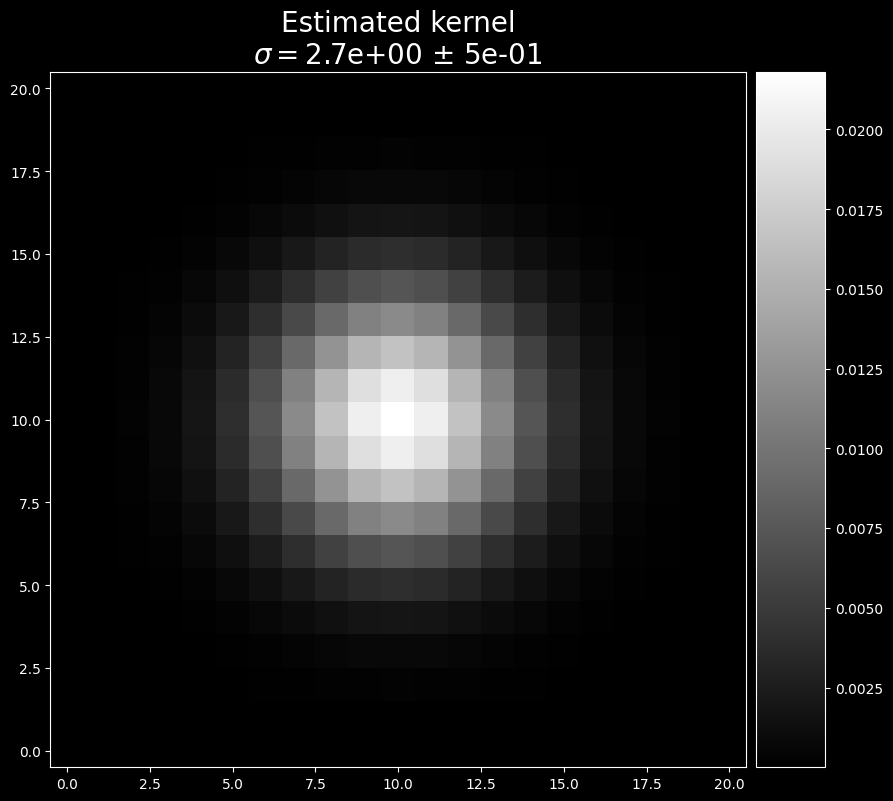

In [7]:
obj_param = [[],[],[],[]]
objs, errs, pos = rst.searching(sci_frame, mean_bkg+Dmean_bkg, mean_bkg, errs=sigma, max_size=max_size, num_objs=10, cntrl=20, cntrl_mode='bright',obj_params=obj_param, display_fig=False,log=True)

ker_sigma, ker_Dsigma = rst.kernel_estimation(objs, errs, m_bkg,obj_param=obj_param, display_plot=False,**kwargs)
kernel = stf.Gaussian(ker_sigma)


#### II method

In [8]:
# def find_maxima(data, display_plots: bool = False):
#     xpos_max = np.argmax(data,axis=1)
#     ypos_max = np.argmax(data,axis=0)
#     pos_arr = np.arange(len(xpos_max))
#     mat_xpos = [ (xpos_max[i],i) for i in pos_arr]
#     mat_ypos = [ (i,ypos_max[i]) for i in pos_arr]
#     match_pos = [ i in mat_ypos for i in mat_xpos]
#     matches = np.array(mat_xpos)[match_pos].T
#     if display_plots:
#         plt.figure(figsize=(13,13))
#         plt.imshow(data,cmap='gray',origin='lower')
#         # plt.plot(xpos_max,pos_arr,'+',color='red')
#         # plt.plot(pos_arr,ypos_max,'x',color='blue')
#         plt.plot(*matches,'.g')
#         plt.show()
#     print(data[matches[0],matches[1]])
#     print(np.sort(data[matches[0],matches[1]]))
#     sort_pos = np.argsort(data[matches[0],matches[1]])[::-1]
#     print(sort_pos)
#     matches = matches[:,sort_pos]
#     return matches

# tmp_sci_frame = sci_frame.copy()
# tmp_ind = find_maxima(sci_frame,True)
# plt.figure()
# plt.imshow(sci_frame,origin='lower')
# plt.plot(*tuple(tmp_ind.T[0]),'o')
# plt.show()
# for tmpi in tmp_ind.T:
#     tmpi = tuple(tmpi[::-1])
#     print(tmpi)  
#     tmp_xmax, tmp_ymax = tmpi
#     if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
#         if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: 
#             print(tmp_sci_frame[tmp_xmax,tmp_ymax])
#             break
#         xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
#         # compute slices
#         tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
#         tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
#         # define the object
#         tmp_obj = sci_frame[tmp_x,tmp_y].copy()
#         tmp_sci_frame[tmp_x,tmp_y] = 0.0
#         # plt.figure()
#         # plt.imshow(tmp_obj,cmap='gray',origin='lower')
#         # plt.figure()
#         # plt.imshow(tmp_sci_frame,cmap='gray',origin='lower')
#         # plt.show()
# tmp_ind = find_maxima(tmp_sci_frame,True)
# for tmpi in tmp_ind.T:
#     tmpi = tuple(tmpi[::-1])
#     print(tmpi)  
#     tmp_xmax, tmp_ymax = tmpi
#     if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
#         if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
#         xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
#         # compute slices
#         tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
#         tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
#         # define the object
#         tmp_obj = sci_frame[tmp_x,tmp_y].copy()
#         tmp_sci_frame[tmp_x,tmp_y] = 0.0
# tmp_ind = find_maxima(tmp_sci_frame,True)
# for tmpi in tmp_ind.T:
#     tmpi = tuple(tmpi[::-1])
#     print(tmpi)  
#     tmp_xmax, tmp_ymax = tmpi
#     if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
#         if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
#         xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
#         # compute slices
#         tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
#         tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
#         # define the object
#         tmp_obj = sci_frame[tmp_x,tmp_y].copy()
#         tmp_sci_frame[tmp_x,tmp_y] = 0.0
# tmp_ind = find_maxima(tmp_sci_frame,True)
# for tmpi in tmp_ind.T:
#     tmpi = tuple(tmpi[::-1])
#     print(tmpi)  
#     tmp_xmax, tmp_ymax = tmpi
#     if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
#         if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
#         xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
#         # compute slices
#         tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
#         tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
#         # define the object
#         tmp_obj = sci_frame[tmp_x,tmp_y].copy()
#         tmp_sci_frame[tmp_x,tmp_y] = 0.0
# dpl.fast_image(tmp_sci_frame)


#### I method

In [9]:
# Dmean_bkg = sigma_bkg
# trial = sci_frame - mean_bkg
# # extract objects for the kernel recovery
# objs, errs, pos = rst.searching(sci_frame, mean_bkg+Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
# # objs, errs, pos = rst.searching(trial, Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
# obj0 = np.copy(objs[0])
# # estimate kernel
# ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], m_bkg, display_plot=False,**kwargs)
# # ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], (0,Dmean_bkg), display_plot=False,**kwargs)
# # compute the estimated kernel
# kernel = stf.Gaussian(ker_sigma)


In [10]:

# prb_obj = obj0
# prb_x, prb_y = pos[:,0]
# avg_cen = np.where(prb_obj == sci_frame[prb_x,prb_y])
# avg_dist, avg_obj = rst.average_trend(prb_obj,avg_cen)
# avg_obj -= mean_bkg
# plt.figure()
# plt.plot(avg_dist,avg_obj,'.--')

# def gauss_func(x,*args):
#     k,mu,sigma = args
#     z = (x-mu)/sigma
#     return k * np.exp(-z**2/2)
# from scipy.optimize import curve_fit
# avgmax = np.argmax(avg_obj)
# hm = avg_obj[avgmax]/2
# hm_pos = np.argmin(abs(hm-avg_obj))
# hwhm = abs(avg_dist[avgmax]-avg_dist[hm_pos])
# initial_values = [2*hm,0,ker_sigma]
# pop, pcov = curve_fit(gauss_func,avg_dist,avg_obj,initial_values)
# print(pop,np.sqrt(pcov.diagonal()))
# xx = np.linspace(0,avg_dist.max(),100)
# plt.plot(xx,gauss_func(xx,*pop))
# plt.plot(xx,gauss_func(xx,*initial_values))

# xdim, ydim = prb_obj.shape
# yrange, xrange = np.meshgrid(np.arange(xdim),np.arange(ydim))
# zeta = np.sqrt((xrange-avg_cen[0])**2+(yrange-avg_cen[1])**2)/pop[-1]
# rec_obj = np.exp(-zeta**2/2)
# rec_obj = pop[0]*rec_obj+mean_bkg
# print(prb_obj[avg_cen])
# print(rec_obj[avg_cen])
# plt.figure()
# plt.imshow(prb_obj)
# plt.figure()
# plt.imshow(rec_obj)
# plt.figure()
# plt.imshow(prb_obj-rec_obj)
# plt.show()


### R-L

Dn 3.287957273492202e-06
Dn 7.61494485383958e-07
Dn 1.5605337870577437e-06
1615: - diff 1.559e-06	chisq 3.307e-10
Time: 49.58375263214111 s



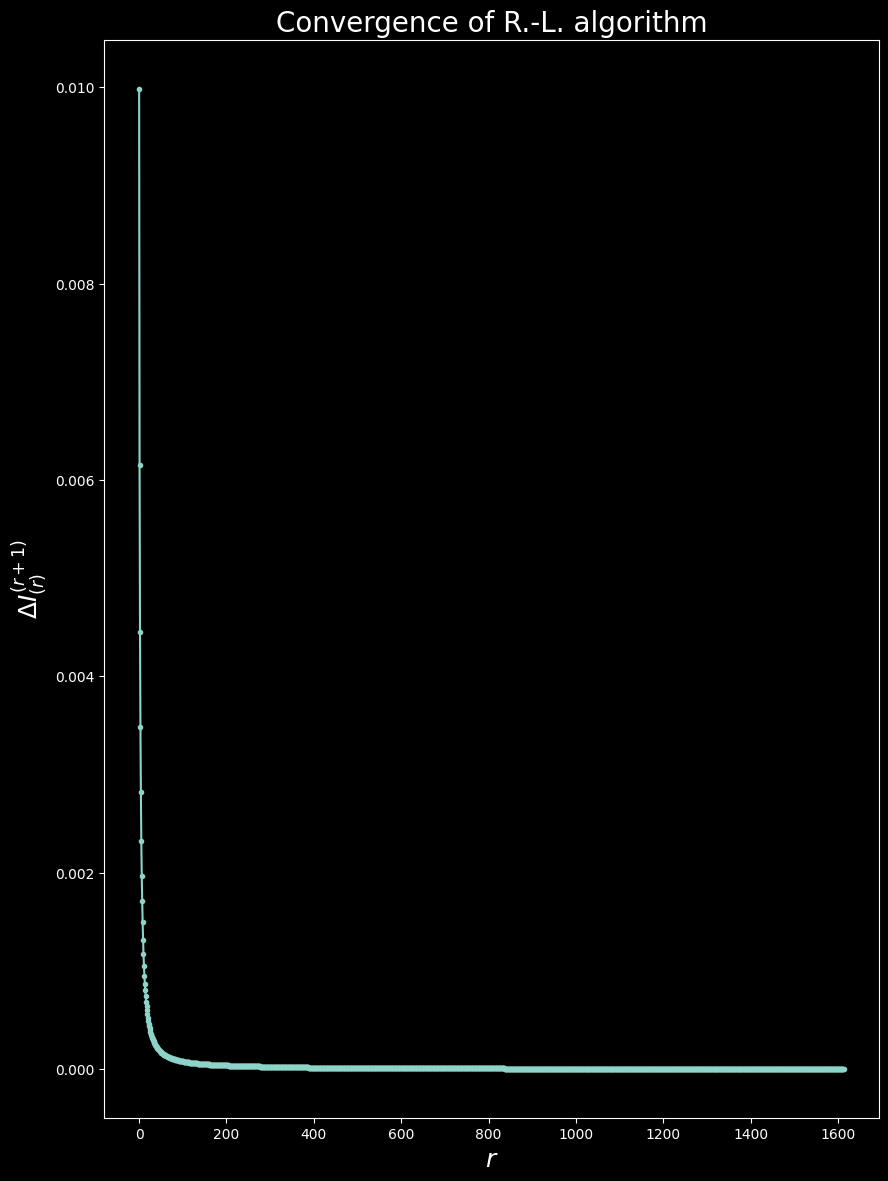

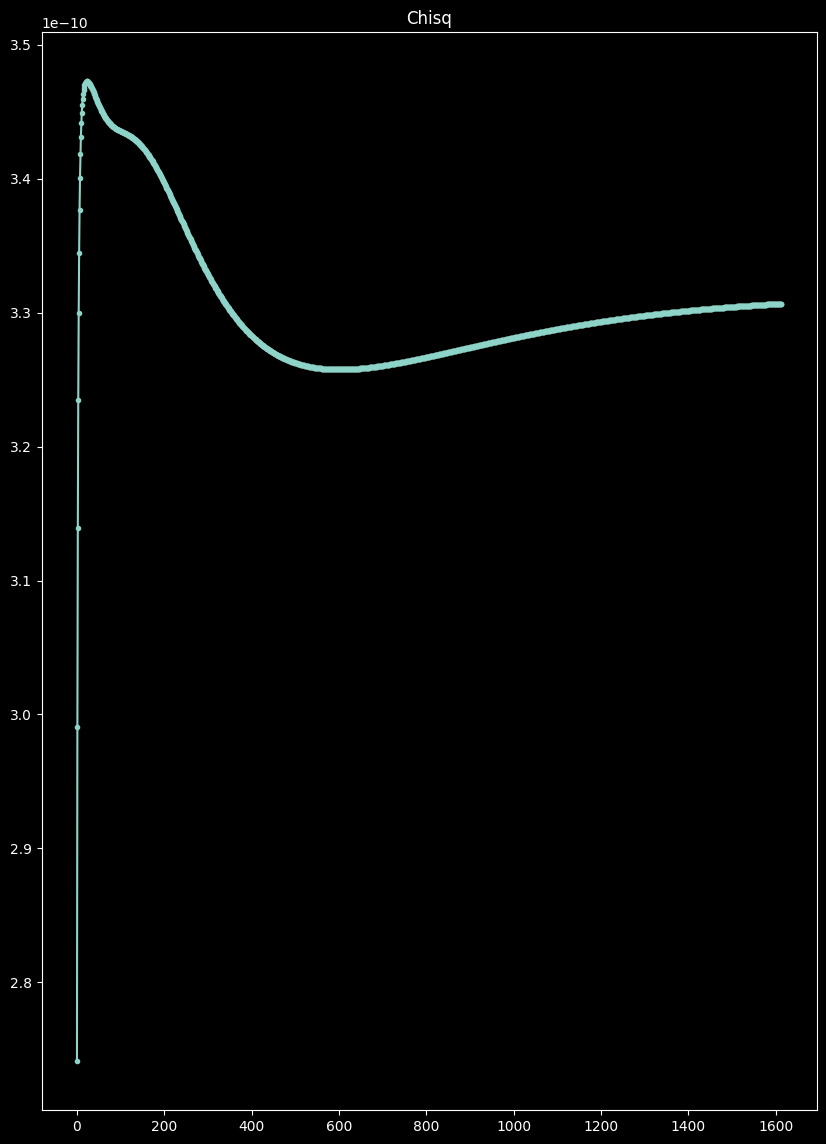

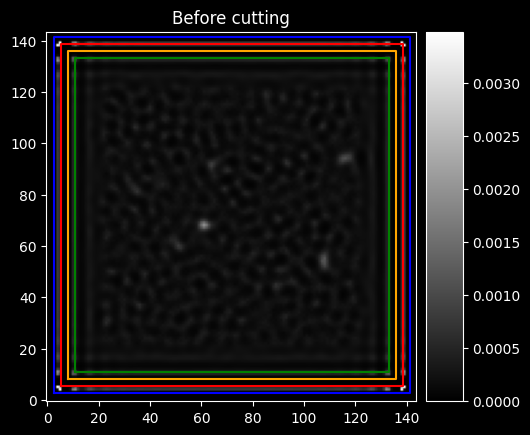

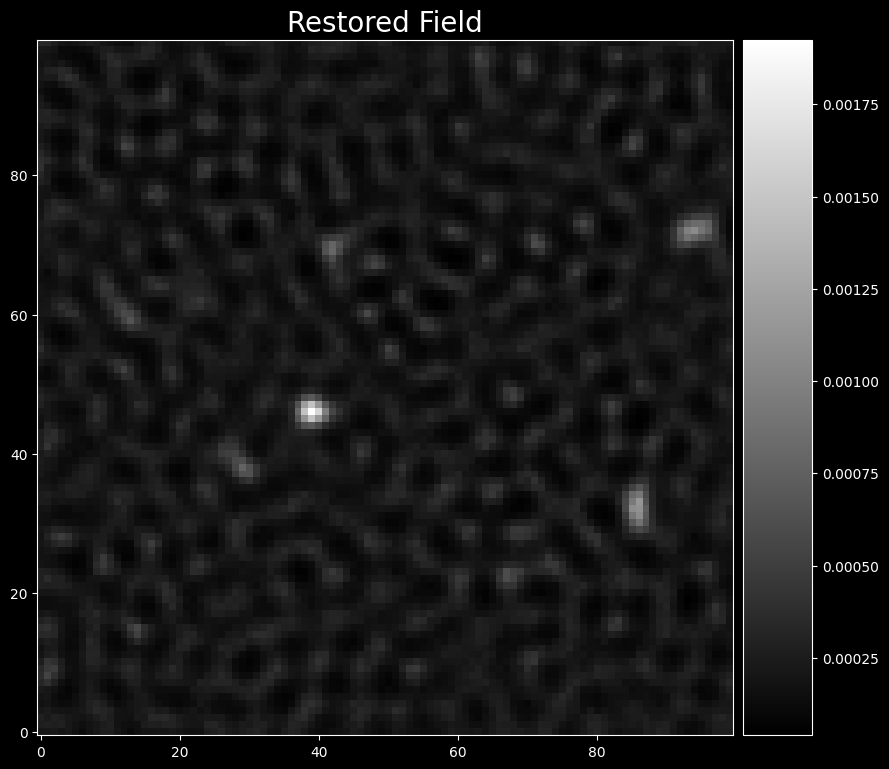

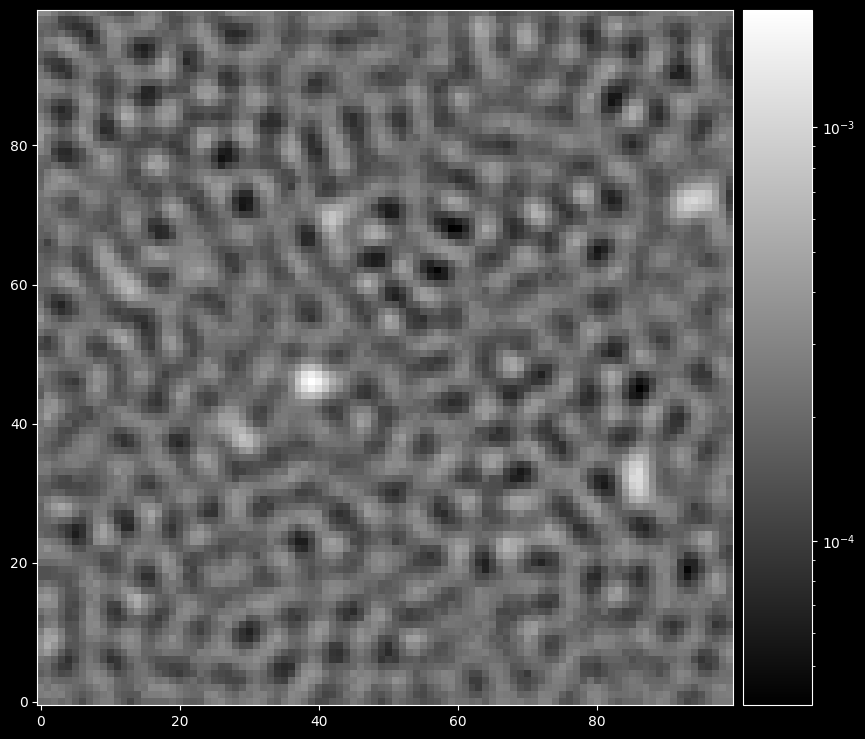

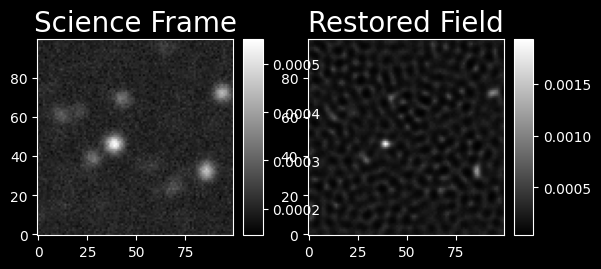

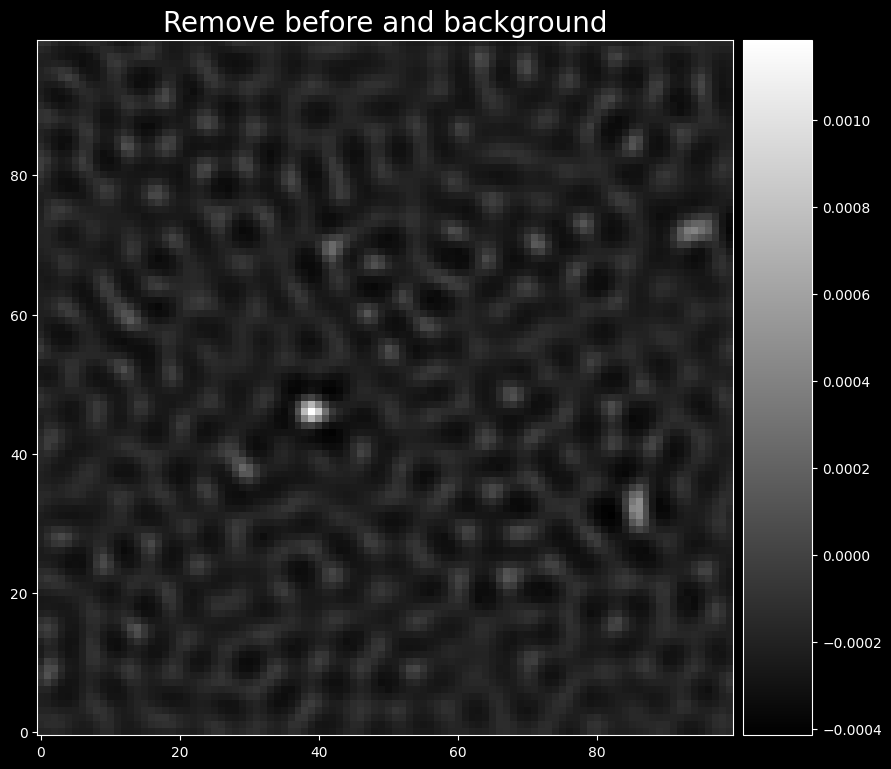

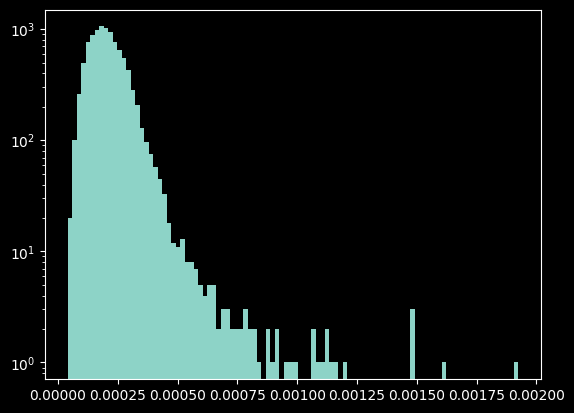

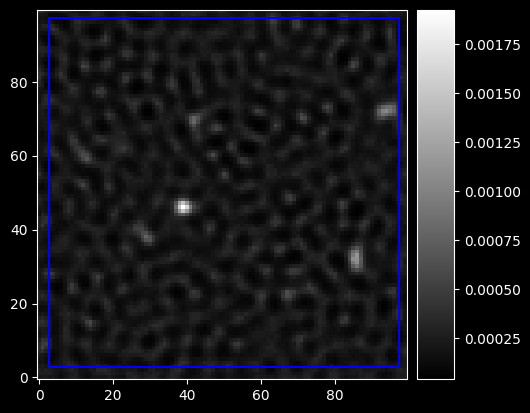

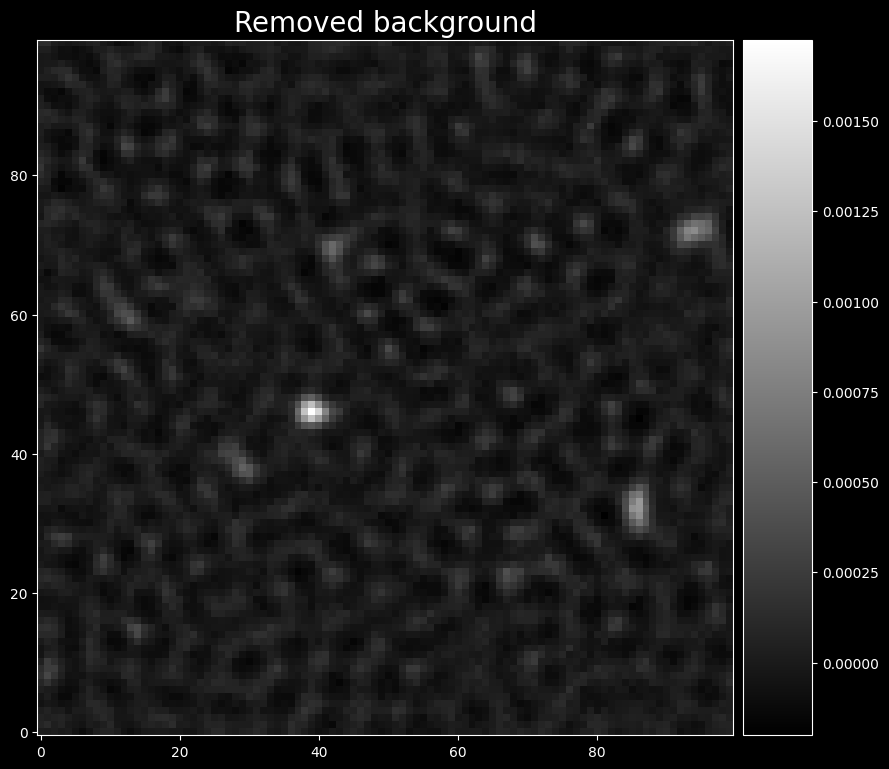

In [11]:
thr_mul = 1/sci_frame.sum()
# thr_mul = 1/mean_bkg
# mode = {'fillvalue': 0}
# mode = {'boundary': 'symm'}
mode = None
rec_field = rst.LR_deconvolution(sci_frame,kernel,sigma, mean_bkg, sigma_bkg,mode=mode,thr_mul=thr_mul, display_fig=True)
dpl.fast_image(rec_field - sci_frame - mean_bkg,'Remove before and background')
flat_field = rec_field.flatten()
plt.figure()
plt.hist(flat_field,100)
plt.yscale('log')

fig, ax = plt.subplots(1,1)
dim = len(rec_field)
dpl.field_image(fig, ax, rec_field)
mask0 = sqr_mask(ker_sigma, dim)
ax.plot(mask0[:,0], mask0[:,1], color='blue')
plt.show()

last_sen += [f'L2: {rec_field.max()*np.sqrt(18*np.pi)}']
art_bkg = stf.Gaussian(sigma_bkg, mean_bkg).field(rec_field.shape)
dpl.fast_image(rec_field - art_bkg, 'Removed background')



In [12]:
from skysimulation import peak_pos,fast_image,field_image,NDArray,minimum_pos
from skysimulation.restoration import selection,new_grad_check,object_check,Literal,new_kernel_fit
def art_obj(prb_obj: NDArray, index: tuple[int,int], bkg_val: float, errs: NDArray | None = None, ker_sigma: float | None = None, debug_plots: bool = False) -> tuple[NDArray,NDArray] | tuple[None,None]:
    fit_obj = prb_obj.copy() - bkg_val
    # prb_x, prb_y = index
    avg_cen = index 
    def gauss_func(pos, *args):
        xpos, ypos = pos
        k, s, x0, y0 = args
        zx = (xpos-x0)/s
        zy = (ypos-y0)/s
        return k * np.exp(-zx**2/2) * np.exp(-zy**2/2)
    xdim, ydim = prb_obj.shape
    # xrange, yrange = np.meshgrid(np.arange(ydim),np.arange(xdim))
    yrange, xrange = np.meshgrid(np.arange(ydim),np.arange(xdim))
    from scipy.optimize import curve_fit
    try:
        k0 = fit_obj[index]
    except:
        if debug_plots:
            fast_image(fit_obj)
        print(index)
        raise
    if ker_sigma is None:
        hm = k0/2
        hm_xpos, hm_ypos = minimum_pos(abs(hm-fit_obj))
        hwhm = np.sqrt((hm_xpos - index[0])**2 + (hm_ypos - index[1])**2)
        ker_sigma = hwhm   
    initial_values = [k0,ker_sigma,index[0],index[1]]  
    xfit = np.vstack((xrange.ravel(),yrange.ravel()))
    yfit = fit_obj.ravel()
    sigma = errs.ravel().copy() if errs is not None else None

    try:
        pop, pcov = curve_fit(gauss_func,xfit,yfit,initial_values,sigma=sigma)
        print(pop,np.sqrt(pcov.diagonal()))
    except RuntimeError:
        try:
            if debug_plots:        
                plt.figure()
                plt.title('runtime0')
                plt.imshow(fit_obj)
                plt.plot(index[1],index[0],'.')
                plt.show()
            print('Another Chance')
            _ = new_kernel_fit(fit_obj,display_fig=debug_plots)
            exit()
            # pop, pcov = curve_fit(gauss_func,xfit,yfit,initial_values,sigma=None)
            # print(pop,np.sqrt(pcov.diagonal()))
        except RuntimeError:
            if debug_plots:        
                plt.figure()
                plt.title('runtime')
                plt.imshow(fit_obj)
                plt.show()
            print('RuntimeError in rec_obj')
            return None, None
    except ValueError:
        print('YOHEY',errs.shape,fit_obj.shape)
        raise
    if pop[1] < 1:
        return None,None
    rec_obj = gauss_func((xrange,yrange),*pop) + bkg_val
    print('VARIANCE',np.sqrt(np.var(rec_obj-prb_obj)))
    rec_err = np.full(rec_obj.shape,np.sqrt(np.var(rec_obj-prb_obj)))
    if rec_obj.shape != prb_obj.shape:
        print('Probe',xdim,ydim)
        print(xrange)
        print(yrange)
        print(avg_cen)
        print(rec_obj.shape)
        fast_image(prb_obj)
        fast_image(rec_obj)
    print('CENVAL',prb_obj[avg_cen])
    print('CENVAL',rec_obj[avg_cen])
    dim = 2*int(4*pop[1])+1
    cen = dim // 2
    yrange, xrange = np.meshgrid(np.arange(dim),np.arange(dim))
    new_obj = gauss_func((xrange,yrange),pop[0],pop[1],cen,cen)
    new_err = np.full(new_obj.shape,np.std(rec_obj-prb_obj))
    return new_obj, new_err


## Find Stars

In [13]:

def searching(field: NDArray, thr: float, bkg_val: float, errs: NDArray | None = None, max_size: int = 5, min_dist: int = 0, ker_sigma: float | None = None, num_objs: int | None = None, cntrl_mode: Literal['bright', 'low', 'all'] = 'all', debug_plots: bool = False, cntrl: int | None = None, cntrl_sel: str | None = None, display_fig: bool = False, **kwargs) -> None | tuple[list[NDArray], list[NDArray] | None, NDArray]:
    if 'log' not in kwargs.keys():
        kwargs['log'] = False
    if 'debug_check' not in kwargs.keys():
        kwargs['debug_check'] = False
    debug_check = kwargs['debug_check']
    kwargs.pop('debug_check')
    def info_print(cnt: int, index: tuple, peak: float) -> None:
        x0 , y0 = index
        if kwargs['log']:
            print(f'\n- - - -\nStep {cnt}')
            print(f'\tcoor : ({x0}, {y0})')
            print(f'\tpeak : {peak}')
    tmp_field = field.copy()
    display_field = field.copy()
    sigma = []
    arr_pos = np.empty((2,0),dtype=int)
    acc_obj = []
    err_obj = []
    acc_pos = np.empty((2,0),dtype=int)
    rej_obj = []
    rej_pos = np.empty((2,0),dtype=int)
    
    # first step
    xmax, ymax = peak_pos(tmp_field)    #: coordinates of the maximum
    peak = tmp_field[xmax, ymax]        #: maximum value
    stop_val = thr                      #: threashold
    cnt = 1
    obj_cnt = 0
    print('\n- - - SEARCHING START - - -')
    print(f'Stop_val : {stop_val}')
    info_print(cnt,(xmax, ymax), peak)
    while peak > stop_val:
        # debug_plots = True if cnt == 2 else False
        # debug_check = True if cnt == 2 else False
        rec_obj = None
        # compute an estimation of the size of the object
        xsize, ysize = new_grad_check(tmp_field, (xmax, ymax), thr, size=max_size)
        # compute slices
        x = slice(xmax - xsize[0], xmax + xsize[1]+1)
        y = slice(ymax - ysize[0], ymax + ysize[1]+1)
        # define the object
        obj = field[x,y].copy()
        # if cnt == 2: 
        #     cxmax, cymax = peak_pos(obj)
        #     plt.figure()
        #     plt.imshow(obj)
        #     plt.plot(cymax,cxmax,'.')
        #     plt.plot(ysize[0],xsize[0],'.')
        err = errs[x,y].copy() if errs is not None else None
        # if obj_cnt == 0:
        #     print(xsize,ysize)
        #     fast_image(obj)
        if 0 in obj.shape: 
            fast_image(obj)
            fig, ax = plt.subplots(1,1)
            field_image(fig,ax,field)
            ax.plot(ymax,xmax,'.')
            plt.show()

        #?
        if debug_plots: fast_image(obj,'Object')
        #?
        if kwargs['log']: print('SHAPE: ',obj.shape)
        # remove small object
        if obj.shape[0] <= 3 or obj.shape[1] <= 3:
                if kwargs['log']: 
                    print('xsize',xsize)
                    print('ysize',ysize)
                    print('diff',ymax-ysize)
                    print('Shape no Good')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #? 
                if debug_plots:          
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
        else:
            if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = False
            cxmax, cymax = peak_pos(obj)
            # if cnt == 3: 
            #     plt.figure()
            #     plt.imshow(obj)
            #     plt.plot(cymax,cxmax,'.')
            #     plt.plot(ysize[0],xsize[0],'.')
            #     plt.show()
            if kwargs['log']:
                print('          c s')
                print('x compare',cxmax,xsize)
                print('y compare',cymax,ysize)
            remove_cond = False
            while cxmax != xsize[0] or cymax != ysize[0]:
                #?
                if debug_plots:    
                    ff, aa = plt.subplots(1,1)
                    ff.suptitle('Have to reduce')            
                    field_image(ff,aa,obj)
                    aa.plot(cymax,cxmax,'.r')
                    aa.plot(ysize[0],xsize[0],'.b')
                    plt.show()
                #?
                row = min(cxmax, obj.shape[0]-cxmax-1)
                col = min(cymax, obj.shape[1]-cymax-1)
                condition = row <= col if all([cxmax != xsize[0], cymax != ysize[0]]) else cymax == ysize[0]
                if condition:
                    if kwargs['log']: print('row',cxmax, obj.shape[0]-cxmax-1)
                    xsize = np.array([xsize[0]-cxmax-1, xsize[1]]) if cxmax < xsize[0] else np.array([xsize[0], cxmax-xsize[0]-1])
                    if kwargs['log']: print(xsize)
                else:
                    if kwargs['log']: print('col',cymax, obj.shape[1]-cymax-1)
                    ysize = np.array([ysize[0]-cymax-1, ysize[1]]) if cymax < ysize[0] else np.array([ysize[0], cymax-ysize[0]-1])
                    if kwargs['log']: print(ysize)
                if kwargs['log']:
                    print('x compare',cxmax,xsize)
                    print('y compare',cymax,ysize)
                if (xsize < 0).any() or (ysize < 0).any():
                    raise Exception('Void object')
                # compute slices
                x = slice(xmax - xsize[0], xmax + xsize[1]+1)
                y = slice(ymax - ysize[0], ymax + ysize[1]+1)
                # define the object
                obj = field[x,y].copy()
                if errs is not None:
                    err = errs[x,y].copy()
                if (obj.shape[0] <= 3) or (obj.shape[1] <= 3):
                    if kwargs['log']: print('remove')
                    remove_cond = True
                    break
                cxmax, cymax = peak_pos(obj)
            if remove_cond:            
                if kwargs['log']: print('New Shape is too small')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
            elif peak/2 >= bkg_val:       #: bright objects
                #?
                if debug_plots:                
                    fast_image(obj,'Object before check')
                #?
                if kwargs['log']: print(f'\tshape : {obj.shape}')     
                #?
                if debug_plots:       
                    fig0, ax0 = plt.subplots(1,1)
                    field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check if object is acceptable
                check = object_check(obj, (xmax, ymax), bkg_val, sigma, err=err, debug_plots=debug_plots,**kwargs)
                if check is None or check == -1:
                    print('Check',check)
                    if kwargs['log']: print('Check is not good 1')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                # elif check == -1:
                #     break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if cnt == 38:
                        print('YO',xsize,ysize)
                        plt.figure()
                        plt.imshow(obj)
                        plt.plot(y0-ysize[0],x0-xsize[0],'.')
                        plt.show()
                       
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        axx[0].set_title('Before selection')
                        field_image(figg,axx[0],obj)
                        field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    # check 
                    if selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all',debug_check=debug_check):
                        xcen = x0 - x.indices(xmax)[0]
                        ycen = y0 - y.indices(ymax)[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma,debug_plots=debug_plots)
                        # acc_obj += [obj]
                        if rec_obj is not None:
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            cen = rec_obj.shape[0] // 2
                            xends = (max(0,x0-cen), min(len(tmp_field),x0+cen+1))
                            yends = (max(0,y0-cen), min(len(tmp_field),y0+cen+1))
                            x = slice(*xends)
                            y = slice(*yends)
                            r_xends = (cen-min(x0,cen), min(len(tmp_field)-x0,cen+1)+cen)
                            r_yends = (cen-min(y0,cen), min(len(tmp_field)-y0,cen+1)+cen)
                            r_x = slice(*r_xends)
                            r_y = slice(*r_yends)
                            if np.diff(xends) != np.diff(r_xends) or np.diff(yends) != np.diff(r_yends):
                                print('OOOh')
                                print(np.diff(xends),np.diff(r_xends))
                                print(np.diff(yends),np.diff(r_yends))
                                print(xends,yends)
                                print(r_xends,r_yends)
                                raise
                            try:
                                display_field[x,y] -= rec_obj[r_x,r_y]
                            except ValueError:
                                print('OOOh2')
                                print(xends,yends)
                                print(r_xends,r_yends)                                
                                plt.figure()
                                plt.imshow(display_field[x,y])
                                plt.figure()
                                plt.imshow(rec_obj[x,y])
                                plt.figure()
                                plt.imshow(obj[x,y])
                                plt.show()
                                raise
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)

                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No for selection')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
            else:       #: faint objects
                if kwargs['log']: print('** LOW **')
                if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = True
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                if cnt == 38:
                    plt.figure()
                    plt.title('Before check')
                    plt.imshow(obj)
                    plt.figure()
                    plt.title('Before check')
                    plt.imshow(display_field[xmax-10:xmax+11,ymax-10:ymax+11])
                    plt.show()
                # check whether the object is acceptable
                check = object_check(obj, (xmax, ymax), bkg_val, sigma, mode='low', err=err, maxpos=(xsize[0],ysize[0]), debug_plots=debug_plots)
                if check is None:
                    if kwargs['log']: print('Check is not good 2')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                elif check == -1:
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    print('No for -1')
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                    break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if cnt == 38:
                        plt.figure()
                        plt.title('After check')
                        plt.imshow(obj)
                        plt.figure()
                        plt.title('After check')
                        plt.imshow(display_field[x0-10:x0+11,y0-10:y0+11])
                        plt.show()
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        field_image(figg,axx[0],obj)
                        field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    if selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all',debug_check=debug_check):
                        xcen = x0 - x.indices(len(display_field))[0]
                        ycen = y0 - y.indices(len(display_field))[0]
                        rec_obj, rec_err = art_obj(obj,(xcen,ycen),bkg_val=bkg_val,errs=err,ker_sigma=ker_sigma, debug_plots=debug_plots)
                        if rec_obj is not None:
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [rec_err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            cen = rec_obj.shape[0] // 2
                            xends = (max(0,x0-cen), min(len(tmp_field),x0+cen+1))
                            yends = (max(0,y0-cen), min(len(tmp_field),y0+cen+1))
                            x = slice(*xends)
                            y = slice(*yends)
                            r_xends = (cen-min(x0,cen), min(len(tmp_field)-x0,cen+1)+cen)
                            r_yends = (cen-min(y0,cen), min(len(tmp_field)-y0,cen+1)+cen)
                            r_x = slice(*r_xends)
                            r_y = slice(*r_yends)
                            if np.diff(xends) != np.diff(r_xends) or np.diff(yends) != np.diff(r_yends):
                                print('OOOh')
                                print(xends,yends)
                                print(r_xends,r_yends)
                                raise
                            try:
                                display_field[x,y] -= rec_obj[r_x,r_y]
                            except ValueError:
                                print('OOOh2')
                                print(xends,yends)
                                print(r_xends,r_yends)                                
                                plt.figure()
                                plt.imshow(display_field[x,y])
                                plt.figure()
                                plt.imshow(rec_obj[r_x,r_y])
                                plt.figure()
                                plt.imshow(rec_obj)
                                plt.figure()
                                plt.imshow(obj)
                                plt.show()
                                raise
                        else:
                            if kwargs['log']: print('rec_obj is None')
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No good for selection low obj')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
        # collect coordinates of the centre
        arr_pos = np.append(arr_pos, [[x0], [y0]], axis=1)
        
        if rec_obj is None:
            tmp_field[x,y] = 0.0
        else:
            try:
                # update the field
                tmp_field[x,y] -= rec_obj[r_x,r_y]
            except:
                print(x,y)
                print(x0,y0)
                print(xcen,ycen)
                fast_image(rec_obj)
                fast_image(obj)
                fast_image(tmp_field[x,y])
                print(tmp_field[x,y].shape)
                print(obj.shape)
                print(rec_obj.shape)
                raise

        old_data = (xmax, ymax)
        # compute the next step
        xmax, ymax = peak_pos(tmp_field)
        #!
        if old_data == (xmax,ymax): 
            edge = lambda centre : slice(max(0,centre-4),min(len(field),centre+4))
            f, a = plt.subplots(1,2)
            f.suptitle('Ripetition')
            field_image(f,a[0],display_field)
            field_image(f,a[1],display_field[edge(arr_pos[0,-1]),edge(arr_pos[1,-1])])
            a[0].plot(arr_pos[1,-1],arr_pos[0,-1],'.')
            fast_image(rej_obj[-1],'Bad')
            raise Exception('! RIPETITION !')
        #!
        peak = tmp_field[xmax, ymax]   
        cnt += 1
        info_print(cnt,(xmax, ymax), peak)
        #?
        if debug_plots: fast_image(tmp_field,'tmp_field')
        #?
        if cnt == cntrl:
            print('Stop for control')
            break
        if obj_cnt == num_objs:
            break
                
    fig, ax = plt.subplots(1,1)
    ax.set_title('Frame after objects extraction',fontsize=20)
    field_image(fig,ax,display_field)
    if len(acc_pos[0]) != 0:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if len(rej_pos[0]) != 0:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if 0 not in rej_pos:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    plt.show()
    fig, ax = plt.subplots(1,1)
    ax.set_title('Searching algorithm',fontsize=20)
    field_image(fig,ax,field)
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    plt.show()
    if 0 in acc_pos.shape: return None
    return acc_obj, err_obj, acc_pos


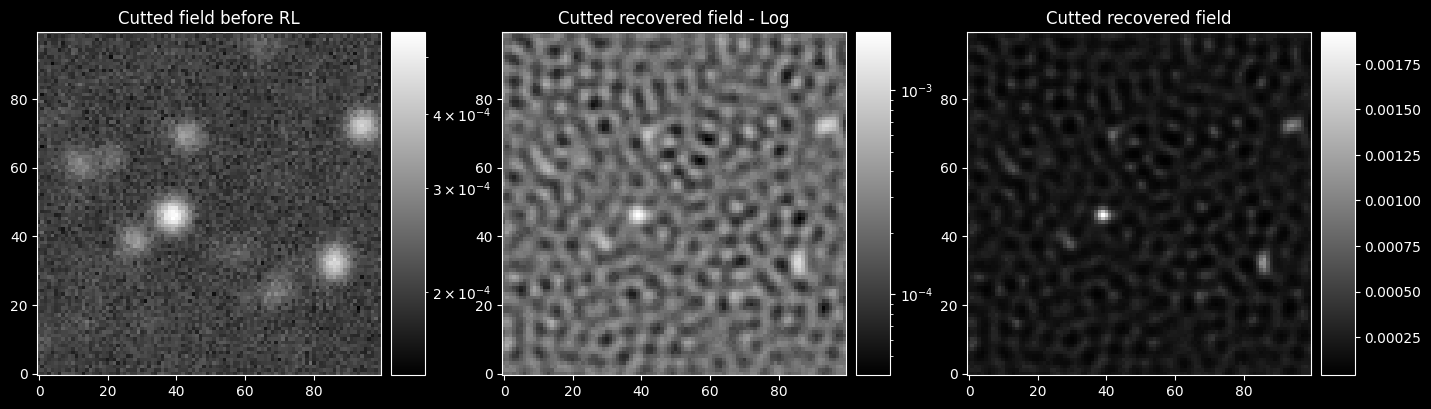

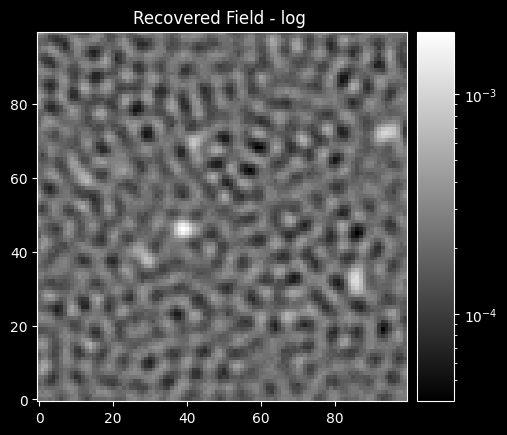


- - - SEARCHING START - - -
Stop_val : 0.00022352944530267582

- - - -
Step 1
	coor : (46, 39)
	peak : 0.0019247106539366963
Max now 46 39
COMPARE 4 [4 5]
COMPARE 5 [5 5]
SHAPE:  (10, 11)
          c s
x compare 4 [4 5]
y compare 5 [5 5]
	shape : (10, 11)

	First cut

	hwhm 2
	hm_pos 7
	sigma 1.4426950408889634
	dim :  10 11
	cen :  4 5
	x :  2 7
	y :  3 8
	val0 0.0019247106539366963
	cen :  2 2
	shift [2 3]
	val1 0.0019247106539366963

sigma0 = 1.0201394465967897
XERR None

Fit results:
	mode : curve_fit
	k: 1.71e-03 +/- 4e-05  -->  2.59 %	init : 0.0017
	sigma: 1.34e+00 +/- 3e-02  -->  2.02 %	init : 1.0
	x0: 1.99e+00 +/- 3e-02  -->  1.72 %	init : 2.0
	y0: 2.06e+00 +/- 3e-02  -->  1.67 %	init : 2.0
	corr_k-sigma	 = -0.74
	corr_k-x0	 = 0.0017
	corr_k-y0	 = -0.0075
	corr_sigma-x0	 = -0.0029
	corr_sigma-y0	 = 0.013
	corr_x0-y0	 = -3.8e-05

	Second cut

	hwhm 2
	hm_pos 7
	sigma 1.4426950408889634
	dim :  10 11
	cen :  4 5
	x :  2 7
	y :  3 8
	val0 0.0019247106539366963
	cen :  2 2
	shift 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/stuff.py:338: RuntimeWarning: invalid value encountered in cast
  order = np.floor(np.log10(number)).astype(int)
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/stuff.py:344: RuntimeWarning: overflow encountered in scalar subtract
  order = val_ord - err_ord
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/restoration.py:344: RuntimeWarning: invalid value encountered in scalar divide
  corr = np.array([ cov[i,j]/np.sqrt(cov[i,i]*cov[j,j]) for i in range(cov.shape[0]) for j in range(i+1,cov.shape[1])])



	hwhm 2
	hm_pos 0
	sigma 1.4426950408889634
	dim :  8 6
	cen :  3 2
	x :  1 6
	y :  0 5
	val0 0.0004252150963355401
	cen :  2 2
	shift [1 0]
	val1 0.0004252150963355401
cut_dim :  5 5
GOOD
xsize (7, 15)
ysize (69, 75)
[2.53568717e-04 9.57183512e-01 3.21894986e+00 1.50327252e+00] [5.01967213e-05 1.35410438e-01 1.87944139e-01 1.88234056e-01]

- - - -
Step 59
	coor : (29, 62)
	peak : 0.0004246750253170413
Max now 29 62
COMPARE 2 [2 3]
COMPARE 2 [2 3]
SHAPE:  (6, 6)
          c s
x compare 2 [2 3]
y compare 2 [2 3]
	shape : (6, 6)
LOW
0 6
0 6

	hwhm 3
	sigma 2.1640425613334453
	dim :  6 6
	cen :  2 2
	x :  0 6
	y :  0 6

sigma0 = 1.4426950408889634
XERR None

Fit results:
	mode : curve_fit
	k: 3e-04 +/- 1e-04  -->  37.24 %	init : 0.00022
	sigma: 8e-01 +/- 2e-01  -->  26.75 %	init : 1.4
	x0: 1.7e+00 +/- 3e-01  -->  17.87 %	init : 2.0
	y0: 1.4e+00 +/- 3e-01  -->  21.19 %	init : 2.0
	corr_k-sigma	 = -0.73
	corr_k-x0	 = -0.032
	corr_k-y0	 = 0.019
	corr_sigma-x0	 = 0.039
	corr_sigma-y0	 = -0.0

/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/restoration.py:284: RuntimeWarning: invalid value encountered in sqrt
  Dpop = np.sqrt(pcov.diagonal())
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/stuff.py:338: RuntimeWarning: divide by zero encountered in log10
  order = np.floor(np.log10(number)).astype(int)
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/restoration.py:344: RuntimeWarning: divide by zero encountered in scalar divide
  corr = np.array([ cov[i,j]/np.sqrt(cov[i,i]*cov[j,j]) for i in range(cov.shape[0]) for j in range(i+1,cov.shape[1])])
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/skysimulation/restoration.py:344: RuntimeWarning: invalid value encountered in sqrt
  corr = np.array([ cov[i,j]/np.sqrt(cov[i,i]*cov[j,j]) for i in range(cov.shape[0]) for j in range(i+1,cov.shape[1])])


XERR None

Fit results:
	mode : curve_fit
	k: 0.0018517362295844247 +/- 932.9368786422151  -->  50381737.08 %	init : 5.7e-05
	sigma: -0.2643143981817416 +/- 19483.61958876276  -->  7371380.34 %	init : 1.0
	x0: 1.5095009973299829 +/- 1407.1679764736296  -->  93220.74 %	init : 2.0
	y0: 3.4961602472585924 +/- 568.6867008209096  -->  16266.04 %	init : 3.0
	corr_k-sigma	 = 1.0
	corr_k-x0	 = -1.0
	corr_k-y0	 = 1.0
	corr_sigma-x0	 = -1.0
	corr_sigma-y0	 = 1.0
	corr_x0-y0	 = -1.0
Check is not good 2

- - - -
Step 361
	coor : (1, 81)
	peak : 0.0002623003853332021
Max now 1 81
COMPARE 1 [1 1]
COMPARE 1 [1 1]
SHAPE:  (3, 3)
xsize [1 1]
ysize [1 1]
diff [80 80]
Shape no Good

- - - -
Step 362
	coor : (34, 10)
	peak : 0.0002620596396961884
Max now 34 10
COMPARE 1 [1 1]
COMPARE 2 [2 1]
SHAPE:  (3, 4)
xsize [1 1]
ysize [2 1]
diff [8 9]
Shape no Good

- - - -
Step 363
	coor : (98, 89)
	peak : 0.00026106800170655595
Max now 98 89
COMPARE 2 [2 1]
COMPARE 1 [1 1]
SHAPE:  (4, 3)
xsize [2 1]
ysize [1 1]
di

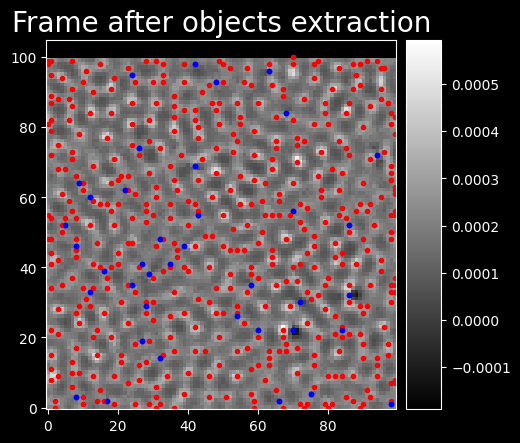

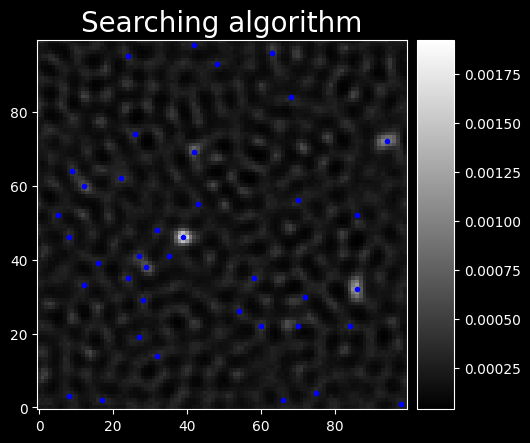

[array([[5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05],
       [5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05],
       [5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05],
       [5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05],
       [5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e-05, 5.92337719e-05,
        5.92337719e-05, 5.92337719e-05, 5.92337719e

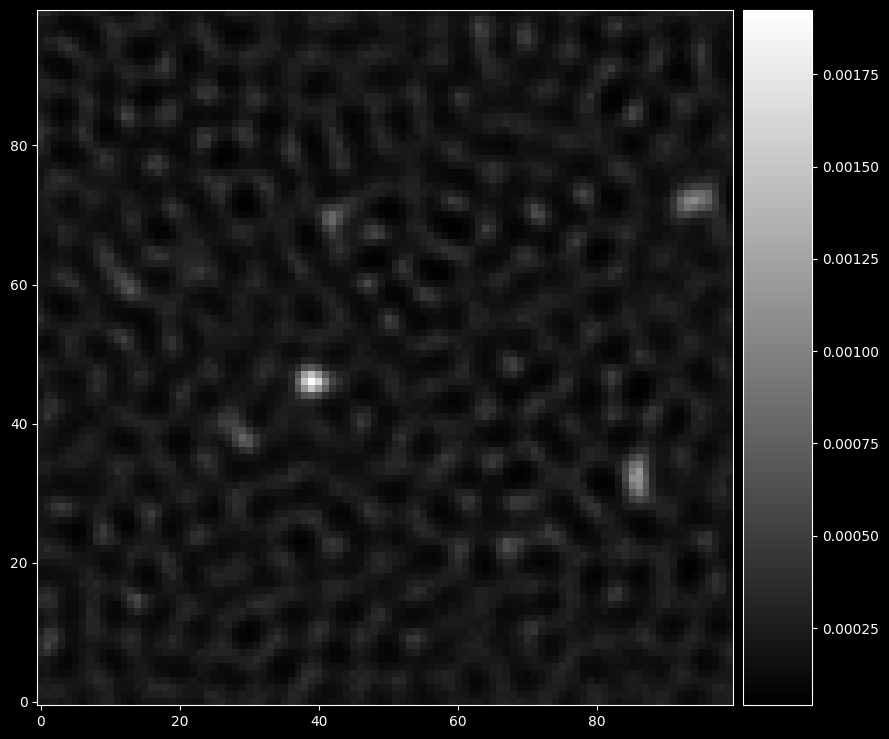

In [14]:
cut_slice = slice(None,None)
# cut_slice = slice(20,-19)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,19))
ax1.set_title('Cutted field before RL')
dpl.field_image(fig,ax1,sci_frame[cut_slice,cut_slice],norm='log')
fig, ax = plt.subplots(1,1)
ax.set_title('Recovered Field - log ')
dpl.field_image(fig,ax,rec_field,norm='log')
tmp_field = rec_field[cut_slice,cut_slice]
ax2.set_title('Cutted recovered field - Log')
dpl.field_image(fig,ax2,tmp_field,norm='log')
ax3.set_title('Cutted recovered field')
dpl.field_image(fig,ax3,tmp_field)
plt.show()
objs, err, obj_pos = rst.searching(tmp_field, mean_bkg+Dmean_bkg, mean_bkg, sel_cond='new', max_size=5, cntrl=None, cntrl_sel='bright', debug_plots=False,log='True')
print(err)
dpl.fast_image(tmp_field)


9.034263640956318
61.61916135268471
49.05504891715248 48.83646178829912


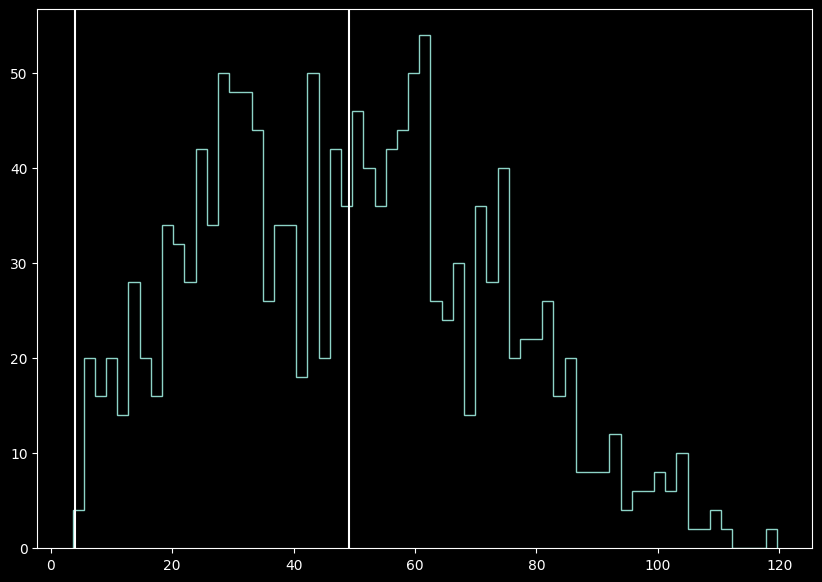

In [15]:
xpos, ypos = obj_pos
distances = np.array([ np.sqrt((xpos-x)**2 + (ypos-y)**2) for x,y in zip(xpos,ypos)]).flatten()
distances = distances[distances!=0]
print(len(sci_frame)/np.sqrt(len(objs)*np.pi))
plt.figure(figsize=(10,7))
cnts, bins, _ = plt.hist(distances,63,histtype='step')
print((bins[1:]+bins[:-1])[cnts.argmax()]/2)
plt.axvline(1.5*ker_sigma,0,1)
plt.axvline(np.mean(distances),0,1)
print(np.mean(distances), np.median(distances))
plt.show()


In [16]:
def compute_mode(counts: list[NDArray], binns: list[NDArray], a_dist: list[NDArray]) -> int:
    _, stars = fld.initialize(p_seed=None)
    sxpos, sypos = stars.pos
    dists = np.array([np.sqrt((sxpos - x)**2 + (sypos - y)**2) for x,y in zip(sxpos,sypos)]).flatten()
    dists = dists[dists!=0]
    cnts, bins = np.histogram(dists,60)
    a_dist += [dists]
    counts += [cnts]
    binns  += [bins]
    bindist = (bins[1:]+bins[:-1])/2
    # return bindist[cnts.argmax()]
    return np.mean(dists)

counts = []
binns  = []
a_dist = [] 

peaks = [ compute_mode(counts,binns,a_dist) for _ in range(3000) ]
a_dist = np.array([*a_dist]).flatten()


52.15780151214489 1.7378486777063293


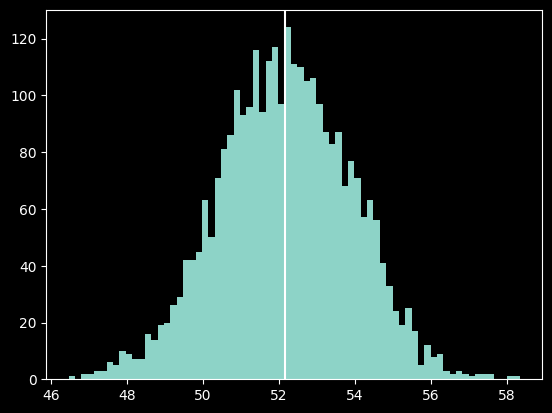

In [17]:
print(np.mean(peaks), np.std(peaks))
plt.figure()
plt.hist(peaks,71)
plt.axvline(np.mean(peaks),0,1)
plt.show()

52.15780151214469 24.79268973946435


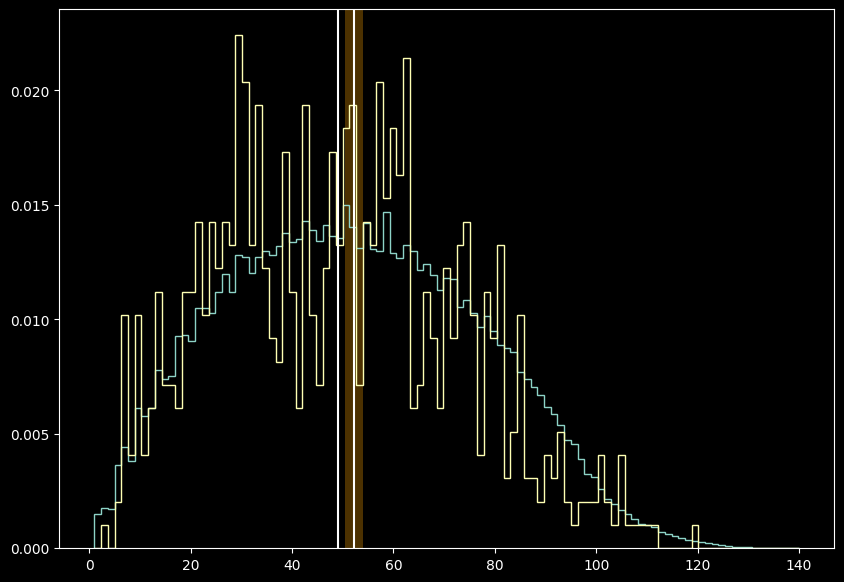

In [18]:
print(np.mean(a_dist), np.std(a_dist))
plt.figure(figsize=(10,7))
cnts, binn, _ = plt.hist(a_dist,105,density=True,histtype='step')
plt.hist(distances,binn,density=True,histtype='step')
plt.axvline(np.mean(distances),0,1)
plt.axvline(np.mean(a_dist),0,1)
plt.axvspan(np.mean(peaks)-np.std(peaks),np.mean(peaks)+np.std(peaks),facecolor='orange',alpha=0.3)
plt.show()

## Lum Recovery

$$ f(M) = M^{-\alpha} $$
$$ L = K\; M^{\beta} $$
$$ f(M)dM = f(L)dL $$
$$ f(L) = \frac{1}{\beta} \Bigl ( \frac{L}{K} \Bigr )^{(1-\alpha-\beta)/\beta} $$

0.0017004397686161189
sigma 2.701961452502659

Luminosities:
L0: 0.01944675839125418
L0.5: 0.0045207179278305394
L1: 0.004140961919296441
L2: 0.014473602436923737
L3: 0.011516760526059284 +/- 0.0020640574037914436
L4: 0.011516760526059284
NO - 3.84
VAL 0.5922200653883135 0.10613889277915416
VAL 0.6098141306685598
Mean Val: 0.0010872693806463372 0.0018722474303985138


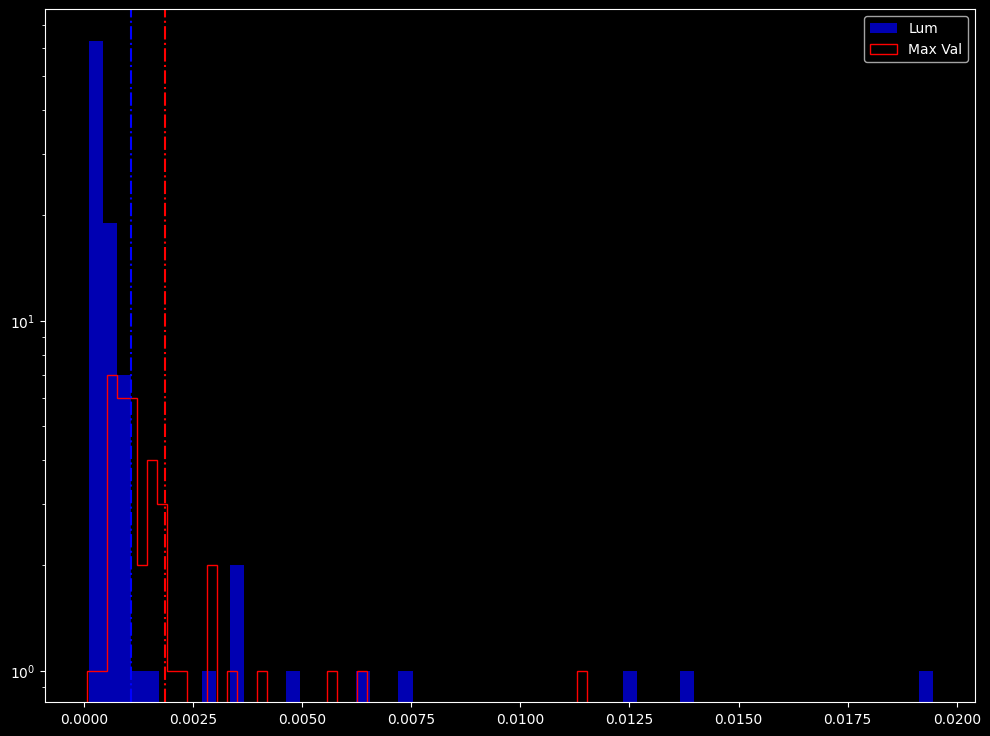



------

FOUND:	39
OBSER:	67


In [19]:
Dmean_bkg = 0
print(objs[0].max())
lum = S.lum
# maxvalues  = np.array([ tmp_field[x,y] for x, y in zip(*obj_pos)])
maxvalues  = np.array([o.max() for o in objs])
maxerr  = np.array([np.sqrt(err[i][stf.peak_pos(objs[i])]**2 + Dmean_bkg**2) for i in range(len(objs))])
val_obj0 = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
err_obj0 = maxerr[maxvalues.argmax()]
err_obj0 = np.sqrt((err_obj0/maxvalues.max())**2 + (ker_Dsigma/ker_sigma)**2) * val_obj0
print('sigma',ker_sigma)
print('\nLuminosities:')
for sen in last_sen:
    print(sen)
print(f'L3: {maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)} +/- {err_obj0}')
print(f'L4: {objs[0].max()*np.sqrt(2*np.pi*ker_sigma**2)}')
val = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
print('OK' if val - err_obj0 <= lum.max() <= val + err_obj0 else 'NO', f'- {abs(val-lum.max())/err_obj0:.2f}')
print('VAL',maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)/lum.max(),err_obj0/lum.max())
print('VAL',(maxvalues.max()+m_dark.mean())*np.sqrt(2*np.pi*ker_sigma**2)/lum.max())
maxvalues *= np.sqrt(2*np.pi*ker_sigma**2)
print('Mean Val:',lum.mean(),maxvalues.mean())
# from scipy.integrate import trapezoid
# maxvalues = np.array([ trapezoid(trapezoid(obj)) for obj in objs])
plt.figure(figsize=(12,9))
binnn = lambda arr : 10**(np.linspace(np.log10(arr).min(),np.log10(arr).max(),10))
cnts, binn, _ = plt.hist(lum,60, histtype='barstacked', label='Lum',color='blue',alpha=0.7)
plt.hist(maxvalues,50, histtype='step',color='red',label='Max Val')
plt.axvline(lum.mean(),0,1,linestyle='dashdot',color='blue')
plt.axvline(maxvalues.mean(),0,1,linestyle='dashdot',color='red')
# plt.xscale('log')
# plt.axvline(np.mean(maxvalues),0,1,linestyle='dashed',color='red')
# plt.axvline(np.mean(lum),0,1,linestyle='dashed',color='blue')
# plt.axvline(mean_bkg,0,1,linestyle='-.',color='violet',label='mean_bkg')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()
print(f'\n\n------\n\nFOUND:\t{len(objs)}\nOBSER:\t{len(lum[lum>mean_bkg])}')


39
[0.01958065 0.01532073 0.01464583 0.00678128 0.0066493  0.00507727
 0.0038108  0.00259878 0.00248246 0.00191122 0.00333903 0.00196106
 0.00235678 0.00182117 0.00164458 0.00087599 0.00153355 0.00115831
 0.00152838 0.00120433 0.00143942 0.0010795  0.0011955  0.00124091
 0.001334   0.00144486 0.00089663 0.00104458 0.00093963 0.00117215
 0.00080979 0.00338413 0.00089165 0.00088254 0.00071208 0.0007956
 0.0010737  0.00143386 0.0004793 ]
[0.01944676 0.01384286 0.0126797  0.00746778 0.00642626 0.00477043
 0.00358059 0.00334599 0.00271606 0.00144522 0.00117576 0.00096674
 0.0009601  0.00095853 0.00093977 0.00091455 0.00090976 0.00080526
 0.00074302 0.00073664 0.00070169 0.00070067 0.00069462 0.00069266
 0.00069128 0.00062664 0.00062439 0.00056454 0.00051158 0.0004953
 0.00048914 0.00048636 0.00048466 0.00047868 0.00046942 0.00046277
 0.00045722 0.00042671 0.00041547]


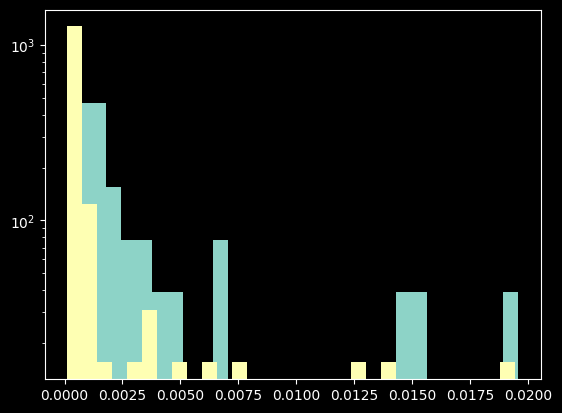

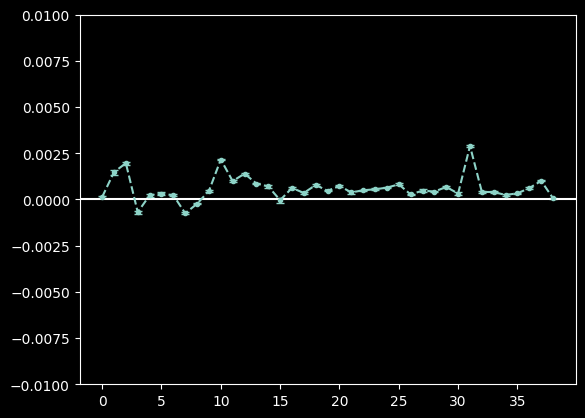

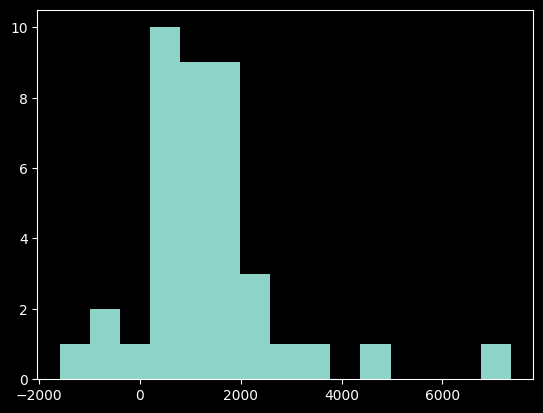

In [20]:
lum = np.sort(lum)[::-1]
sum_val = np.array([ np.sum(obj) for obj in objs])
sum_err = np.array([e[0,0] for e in err])


print(len(sum_val))
print(sum_val)
print(lum[:len(sum_val)])

plt.figure()
plt.hist(sum_val,29,density=True)
plt.yscale('log')
# plt.figure()
plt.hist(lum,30,density=True)
plt.figure()
plt.errorbar(np.arange(len(sum_val)),(sum_val-lum[:len(sum_val)]),sum_err,fmt='.--',capsize=3)
plt.axhline(0,0,1)
plt.ylim(-0.01,0.01)
plt.figure()
plt.hist((sum_val-lum[:len(sum_val)])/sum_err*100,15)
plt.show()

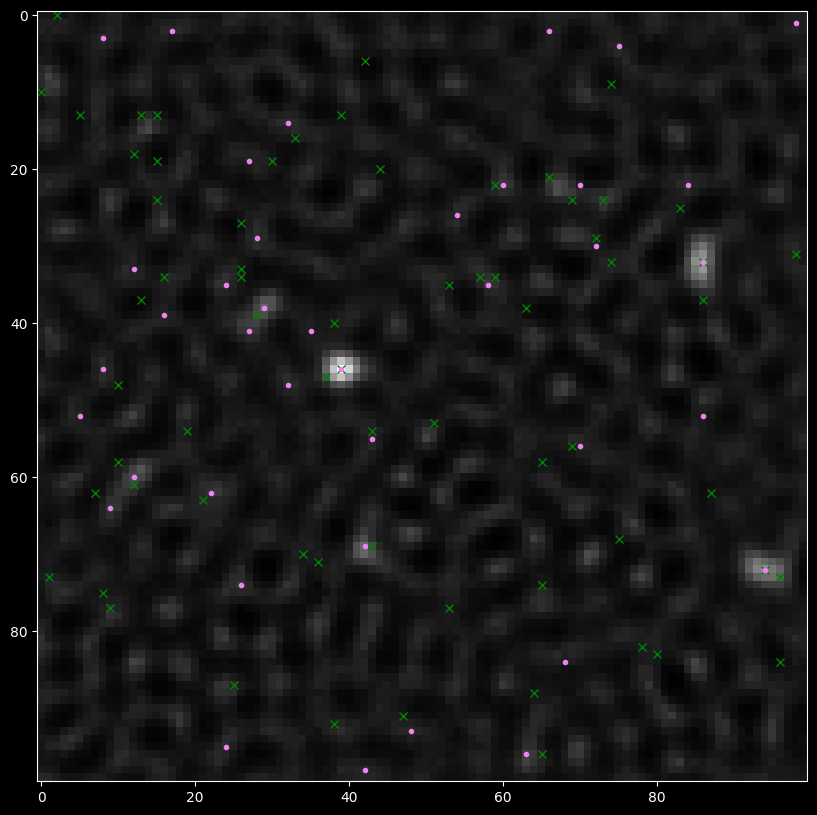

In [21]:
lum_obj_pos = S.lum>mean_bkg+Dmean_bkg
plt.figure(figsize=(13,10))
plt.imshow(rec_field,cmap='gray')
plt.plot(S.pos[1][lum_obj_pos],S.pos[0][lum_obj_pos],'x',color='green')
plt.plot(*obj_pos[::-1,:],'.',color='violet')

s1 31.343283582089555 %
s2 70.1492537313433 %
s3 114.92537313432835 %


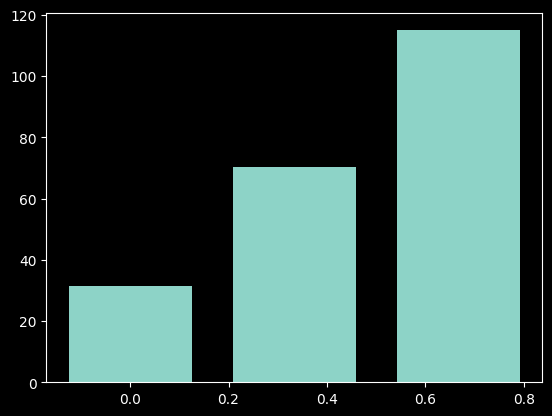

In [30]:
rec_pos = obj_pos
init_pos = np.asarray(S.pos)[:,lum_obj_pos]
def compute_dist(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2,axis=0))

width = 0.25
check = np.array([ compute_dist(rec_pos,np.vstack(init_pos[:,i])) for i in range(init_pos.shape[1])])
s1_cnts = len(np.where(check <=   ker_sigma)[0])/init_pos.shape[1]*100
s2_cnts = len(np.where(check <= 2*ker_sigma)[0])/init_pos.shape[1]*100
s3_cnts = len(np.where(check <= 3*ker_sigma)[0])/init_pos.shape[1]*100
print('s1',s1_cnts,'%')
print('s2',s2_cnts,'%')
print('s3',s3_cnts,'%')
plt.figure()
plt.bar(np.arange(3)/3,[s1_cnts,s2_cnts,s3_cnts],align='center',width=width)
# plt.bar(np.arange(3)+1+width,check.shape[0]-np.asarray([s1_cnts,s2_cnts,s3_cnts]),align='center',width=width)
plt.show()

## Test

In [23]:
# import skysimulation as sks
# import numpy as np
# import matplotlib.pyplot as plt

# F,S =  sks.initialize()
# Fseeing = sks.atm_seeing(F,bkg=sks.Gaussian(0,0))
# fig, ax = plt.subplots(1,1)
# sks.field_image(fig,ax,Fseeing)
# plt.figure()
# bkg = np.median(Fseeing)
# plt.hist(Fseeing.flatten(),100)
# plt.axvline(bkg,0,1)
# plt.show()

# obj,err,pos = sks.searching(Fseeing,bkg,bkg,num_objs=10,log=False)
# sigma, Dsigma = sks.kernel_estimation(obj,err,(bkg,0))


In [24]:
# max_iter = 2000
# mode = {'boundary':'symm'}
# dec_field = sks.LR_deconvolution(Fseeing,sks.Gaussian(sigma),Fseeing*1e-1000,bkg,0,max_iter=max_iter,mode=mode)
# fig, ax = plt.subplots(1,1)
# sks.field_image(fig,ax,dec_field)
# plt.show()



In [25]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,11))
# sks.field_image(fig,ax1,dec_field)
# sks.field_image(fig,ax2,Fseeing)
# plt.show()
# tmp_S = dec_field[10:-10,10:-10]
# objs = []
# pos  = []
# tmp = tmp_S.copy()
# dist = lambda p1,p2: np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
# cnt = 0
# xdim, ydim = tmp.shape
# size = 2
# for _ in range(2000):
#     ipos = [*sks.peak_pos(tmp)]
#     pos += [ipos]
#     xends = (max(0,ipos[0]-size),min(xdim,ipos[0]+size+1))
#     yends = (max(0,ipos[1]-size),min(ydim,ipos[1]+size+1))
#     cut = (slice(*xends),slice(*yends))
#     tmp[cut] = 0
#     if cnt > 0: 
#         p1 = pos[cnt-1]
#         p2 = pos[cnt]
#         print(dist(p1,p2))
#         if dist(p1,p2) <= 20:
#             print('Remove')
#             pos.remove([*p2])
#         else:
#             # if cnt <= 3:
#             #     sks.fast_image(tmp,norm='log')
#             objs += [tmp_S[cut]]
#             cnt += 1
#     else:
#         cnt+=1
# fig, ax = plt.subplots(1,1)
# sks.field_image(fig,ax,tmp_S,norm='log')
# for p in pos:
#     y,x = p
#     ax.plot(x,y,'.b')
# plt.show()

# peaks = np.sort(np.array([o.max() for o in objs]))[::-1]*np.sqrt(2*np.pi*sigma**2)
# lum = np.sort(S.lum)[::-1]

# plt.figure(figsize=(14,11))
# counts, bins, _ = plt.hist(lum,60,alpha=0.4)
# plt.hist(peaks,bins,histtype='step')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()s
# print(lum.mean(),peaks.mean(),abs(lum.mean()-peaks.mean())/lum.mean()*100)
# print(len(lum),len(peaks))
